## Sometimes the frame count does not match the number of sync pulses
<br>We observe two errors: too many frames OR too few frames.
<br>
<br>If there are too many frames, we can compare the native timestamps (from the .h5 file) to the sync timestamps to find where in the recording the mismatch happens (it is usually in the middle of the recording). Then we can correct the mismatch by removing the extra frames then aligning with the sync clock. Use the below code to do so.
<br>
<br>If there are missing frames, the number of native timestamps is actually equal to the number of sync timestamps. So the video itself is missing frames even though it has timestamps for them. I don't yet know how to correctly align in this case. For now we can delete the first few sync timestamps to match the lengths. So far in our recordings, this type of mismatch only occurs for a small number of frames (< 16 so far).

In [1]:
import h5py
import os
import sys

import cv2
import gspread
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from allensdk.brain_observatory.sync_dataset import Dataset

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.behavior_movies import Movie, get_sync_frame_times

In [4]:
%matplotlib notebook

Get Templeton log for experiment list

In [5]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Templeton-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
metadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

# Look for experiments that have frame/sync mismatch

In [6]:
psydir = r'P:\\' # this is the directory that contains all of the mouse folders

### Testing with one subject

iloc[21]: 669117 (pilot_ur) has 114 extra frames
<br>iloc[25]: 676726 (aw_psi) frames = sync (NO weird clock shifts)
<br>iloc[34]: 698242 (aw_psi) has 26 extra frames (clock shift in middle of recording)

In [7]:
testrow = metadata.iloc[90]
print(testrow.mouse_name)

recdir = os.path.join(psydir, testrow.mouse_name, testrow.exp_name, r'experiment1\recording1')
print(recdir)

exp = EEGexp(recdir, preprocess=False, make_stim_csv=False)
sync_data = exp._load_sync_dataset()

mouse735051
P:\\mouse735051\aw_sal_2024-06-12_11-38-41\experiment1\recording1
Experiment type: sensory stimulation


In [8]:
pupilmovie = Movie(filepath=exp.pupilmovie_file, sync_filepath=exp.sync_file, sync_channel='eyetracking')
print('Pupil frame count = {:d}'.format(pupilmovie.frame_count))
print('Pupil sync timestamps = {:d}'.format(len(pupilmovie.sync_timestamps)))

Pupil frame count = 255659
Pupil sync timestamps = 255560


C:\Users\lesliec\code\tbd_eeg\tbd_eeg\data_analysis\Utilities\behavior_movies.py:40: UserWarning: NONMATCHING timestamp counts
There are 255560 timestamps in sync and 255659 timestamps in the associated camera file
these should match
  warnings.warn(f'NONMATCHING timestamp counts\nThere are {len(self.sync_timestamps)} timestamps in sync and {len(self.timestamps_from_file)} timestamps in the associated camera file\nthese should match' )


In [9]:
pupilvid = cv2.VideoCapture(exp.pupilmovie_file)
print('Pupil frame count = {:d}'.format(int(pupilvid.get(cv2.CAP_PROP_FRAME_COUNT))))
pupilsync = sync_data.get_edges(keys=('eyetracking',), kind='rising', units='seconds')
print('Pupil sync count = {:d}'.format(len(pupilsync)))
print('Extra frames = {:d}'.format(int(pupilvid.get(cv2.CAP_PROP_FRAME_COUNT)) - len(pupilsync)))

Pupil frame count = 255659
Pupil sync count = 255560
Extra frames = 99


In [10]:
bodyvid = cv2.VideoCapture(exp.bodymovie_file)
print('Body frame count = {:d}'.format(int(bodyvid.get(cv2.CAP_PROP_FRAME_COUNT))))
bodysync = sync_data.get_edges(keys=('behavior',), kind='rising', units='seconds')
print('Body sync count = {:d}'.format(len(bodysync)))
print('Extra frames = {:d}'.format(int(bodyvid.get(cv2.CAP_PROP_FRAME_COUNT)) - len(bodysync)))

Body frame count = 509633
Body sync count = 509435
Extra frames = 198


### Investigate sync time intervals and frame time intervals

In [11]:
## Load native frame times ##
pupilh5 = h5py.File(exp.pupilmovie_file.replace('.avi','.h5'), 'r')
pupil_ts = np.hstack((0, np.cumsum(pupilh5['frame_intervals'])))

## Load falling edges, intervals between falling edges match frame intervals better ##
pfalling = sync_data.get_edges(keys=('eyetracking',), kind='falling', units='seconds')

In [12]:
print('Pupil frame count = {:d}'.format(int(pupilvid.get(cv2.CAP_PROP_FRAME_COUNT))))
print('Pupil timestamp count = {:d}'.format(len(pupil_ts)))
print('Pupil sync falling edges = {:d}'.format(len(pfalling)))

Pupil frame count = 255659
Pupil timestamp count = 255659
Pupil sync falling edges = 255560


### Some intervals are longer than expected. Do they align?

In [13]:
1/30

0.03333333333333333

In [18]:
tt = 0.02
print(np.nonzero(np.diff(pupil_ts) < tt)[0])
print(np.nonzero(np.diff(pfalling) < tt)[0])

[    10   1610   1940   7210  14460  20010  24610  31250  38080  39640
  39710  39950  41820  47280  85220  85280  87610 101370 103320 103810
 105810 106850 109100 116020 123500 124480 124890 129020 131970 133720
 134540 135110 137030 138350 141210 143520 143530 148310 149700 151620
 153010 157620 161570 161590 165430 175430 177410 178180 179570 182310
 182870 189750 192530 193800 193910 205640 207620 207850 210910 215040
 221130 223500 229180 232530 233710 237310 238370 240270 242130 255620]
[    10   1610   1940   7210  14460  20010  24610  31250  38080  39640
  39710  39851  41721  47181  85121  85181  87511 101271 103221 103711
 105711 106751 109001 115921 123401 124381 124791 128921 131871 133621
 134441 135011 136931 138251 141111 143421 143431 148211 149601 151521
 152911 157521 161471 161491 165331 175331 177311 178081 179471 182211
 182771 189651 192431 193701 193811 205541 207521 207751 210811 214941
 221031 223401 229081 232431 233611 237211 238271 242031 255521]


In [22]:
tt = 0.06
print(np.nonzero(np.diff(pupil_ts) > tt)[0])
print(np.nonzero(np.diff(pfalling) > tt)[0])

[     9    409   3899   9499   9509  14459  20819  27729  29199  38079
  39709  39939  39949  39969  40169  46339  54259  59509  66499  72439
  83009  85219  87279  87449  95799 103319 103809 104339 105389 105809
 106099 106829 108839 109319 109899 113199 113729 116019 121579 124799
 130409 131969 136499 137029 144019 144509 145899 148309 150639 154399
 157609 157619 157709 159629 161569 164079 173729 177409 177609 184829
 185089 185619 191999 192529 193799 195299 195399 196949 197809 201919
 205639 206499 206739 208129 215329 219769 221129 224729 225869 226399
 226969 230529 232529 232609 233099 237309 237839 240439 245319 247199
 248629 249529 254639 255619]
[     9    409   3899   9499   9509  14459  20819  27729  29199  38079
  39709  39840  39850  39870  40070  46240  54160  59410  66400  72340
  82910  85120  87180  87350  95700 103220 103710 104240 105290 105710
 106000 106730 108740 109220 109800 113100 113630 115920 121480 124700
 130310 131870 136400 136930 143920 144410 1458

In [21]:
39840-39939

-99

698242 (aw_psi) = [163165, 163205]
<br> 669117 (pilot_ur) = [139239, 144605]
<br> 689329 (aw_psi) = [61009, 61280]
<br> 735051 (aw_sal) = [39709, 39949]

In [23]:
indwins = [39709, 39949]

<IPython.core.display.Javascript object>


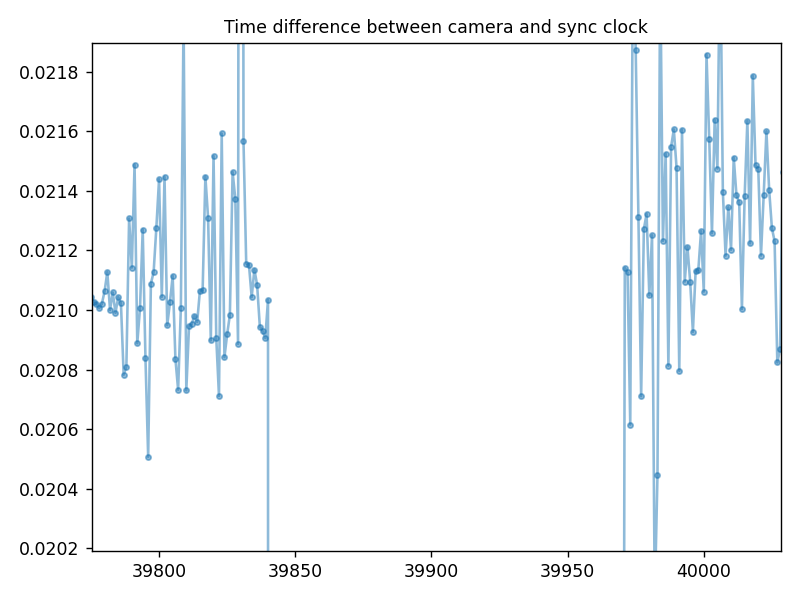

(0.0, 255560.0)

In [36]:
fig, ax = plt.subplots(tight_layout=True)
timediff = (pupil_ts[:len(pfalling)] - pupil_ts[0]) - (pfalling - pfalling[0])
ax.plot(timediff, marker='.', alpha=0.5)
ax.set_title('Time difference between camera and sync clock')
# ax.axvline(indwins[0], color='r', alpha=0.5)
# ax.axvline(indwins[1], color='r', alpha=0.5)
ax.set_xlim(0, len(pfalling))

### Remove extra frame times

In [25]:
len(pupil_ts)

255659

In [19]:
len(pupilsync)

233043

In [26]:
messind = 39775 # 698242-163199, 669117-143986, 689239-61152, 720762ket-138068, 735051aw_sal-39775

if len(pupil_ts) > len(pupilsync):
    num_frames = len(pupil_ts) - len(pupilsync)
    print('There are {:d} extra frames...deleting them.'.format(num_frames))
    new_ts = np.delete(pupil_ts, np.arange(messind, messind+num_frames))
elif len(pupil_ts) < len(pupilsync):
    num_syncs = len(pupilsync) - len(pupil_ts)
    print('There are {:d} extra sync pulses...deleting the extras from the end.'.format(num_syncs))
    new_sync = pupilsync[:len(pupil_ts)]

There are 99 extra frames...deleting them.


#### Test it

<IPython.core.display.Javascript object>


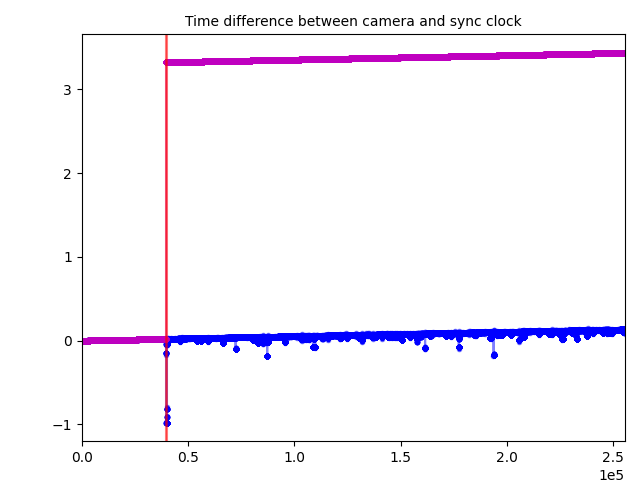

(0.0, 255560.0)

In [27]:
fig, ax = plt.subplots(tight_layout=True)
timediff = (pupil_ts[:len(pfalling)] - pupil_ts[0]) - (pfalling - pfalling[0])
newtimediff = (new_ts - new_ts[0]) - (pfalling - pfalling[0])
ax.plot(timediff, marker='.', color='b', alpha=0.5)
ax.plot(newtimediff, marker='.', color='m', alpha=0.5)
ax.set_title('Time difference between camera and sync clock')
ax.axvline(indwins[0], color='r', alpha=0.5)
ax.axvline(indwins[1], color='r', alpha=0.5)
ax.set_xlim(0, len(pfalling))

## Looks good, now remove frames from pupil .csv

In [28]:
print('Pupil frame count = {:d}'.format(int(pupilvid.get(cv2.CAP_PROP_FRAME_COUNT))))
print('Pupil sync count = {:d}'.format(len(pupilsync)))

Pupil frame count = 255659
Pupil sync count = 255560


In [29]:
files = os.listdir(exp.data_folder)
pupil_file = exp.data_folder + '/' + next(file for file in files if file.split('_')[0] == 'Pupileye')
print(pupil_file)

P:\\mouse735051\aw_sal_2024-06-12_11-38-41\experiment1\recording1/Pupileye_aw_sal_2024-06-12_11-38-41.csv


In [30]:
pupil_data = pd.read_csv(pupil_file)
print(len(pupil_data))
pupil_data.head()

255659


,Time_Frames,X_Position,Y_Position,Radius_1,Radius_2,Angle,Largest_Radius,Eye_Diameter,sync_time
0,0.0,244.285800,218.586389,74.564826,69.495024,1.870316,74.564826,348.385713,NaN
1,1.0,244.435732,218.428615,74.492931,69.577177,1.857789,74.492931,349.570820,NaN
2,2.0,243.919668,218.507594,74.240490,69.372412,1.851867,74.240490,348.298301,NaN
3,3.0,244.123196,218.254287,74.461008,69.677735,1.852918,74.461008,347.999859,NaN
4,4.0,244.145428,218.350246,74.615531,69.605428,1.827661,74.615531,347.972334,NaN


In [31]:
corrected_pupil_data = pupil_data.drop(labels=np.arange(messind, messind+num_frames), axis=0)
print(len(corrected_pupil_data))

255560


In [32]:
corrected_pupil_data['sync_time'] = pupilsync
corrected_pupil_data.head()

,Time_Frames,X_Position,Y_Position,Radius_1,Radius_2,Angle,Largest_Radius,Eye_Diameter,sync_time
0,0.0,244.285800,218.586389,74.564826,69.495024,1.870316,74.564826,348.385713,14.83250
1,1.0,244.435732,218.428615,74.492931,69.577177,1.857789,74.492931,349.570820,14.84621
2,2.0,243.919668,218.507594,74.240490,69.372412,1.851867,74.240490,348.298301,14.86849
3,3.0,244.123196,218.254287,74.461008,69.677735,1.852918,74.461008,347.999859,14.90150
4,4.0,244.145428,218.350246,74.615531,69.605428,1.827661,74.615531,347.972334,14.93494


In [33]:
pupil_data.tail()

,Time_Frames,X_Position,Y_Position,Radius_1,Radius_2,Angle,Largest_Radius,Eye_Diameter,sync_time
255654,255654.0,288.643729,215.241472,108.321783,103.097838,3.097025,108.321783,353.995208,NaN
255655,255655.0,288.846420,215.220290,108.286677,103.231309,3.074013,108.286677,353.841042,NaN
255656,255656.0,288.753065,215.149898,107.694034,103.321496,0.009375,107.694034,353.903376,NaN
255657,255657.0,288.693767,215.123666,107.724963,103.309543,0.014134,107.724963,353.779146,NaN
255658,255658.0,288.698857,215.251600,107.960362,102.864664,0.030196,107.960362,354.940647,NaN


In [34]:
corrected_pupil_data.tail()

,Time_Frames,X_Position,Y_Position,Radius_1,Radius_2,Angle,Largest_Radius,Eye_Diameter,sync_time
255654,255654.0,288.643729,215.241472,108.321783,103.097838,3.097025,108.321783,353.995208,8540.14670
255655,255655.0,288.846420,215.220290,108.286677,103.231309,3.074013,108.286677,353.841042,8540.18005
255656,255656.0,288.753065,215.149898,107.694034,103.321496,0.009375,107.694034,353.903376,8540.21414
255657,255657.0,288.693767,215.123666,107.724963,103.309543,0.014134,107.724963,353.779146,8540.24741
255658,255658.0,288.698857,215.251600,107.960362,102.864664,0.030196,107.960362,354.940647,8540.28326


## Now save pupil .csv with aligned timestamps

In [35]:
corrected_pupil_data.to_csv(pupil_file, index=False)

## Test detrending the line

Doesn't quite work as well as I hoped

In [25]:
slope = np.mean(np.diff(timediff[:indwins[0]]))
detrend_timediff = timediff - slope*np.arange(len(timediff))

In [26]:
fig, ax = plt.subplots(tight_layout=True)
timediff = (pupil_ts[:len(pfalling)] - pupil_ts[0]) - (pfalling - pfalling[0])
ax.plot(timediff, marker='.', color='b', alpha=0.5)
ax.plot(detrend_timediff, marker='.', color='c', alpha=0.5)
ax.set_title('Time difference between camera and sync clock')
ax.axvline(indwins[0], color='r', alpha=0.5)
ax.axvline(indwins[1], color='r', alpha=0.5)
ax.set_xlim(0, len(pfalling))

<IPython.core.display.Javascript object>

(0.0, 174750.0)

In [27]:
avgdt = np.mean(detrend_timediff[:indwins[0]])
print(avgdt)
stddt = np.std(detrend_timediff[:indwins[0]])
print(stddt)

0.0002873595475388248
0.00016291322289725186


<IPython.core.display.Javascript object>


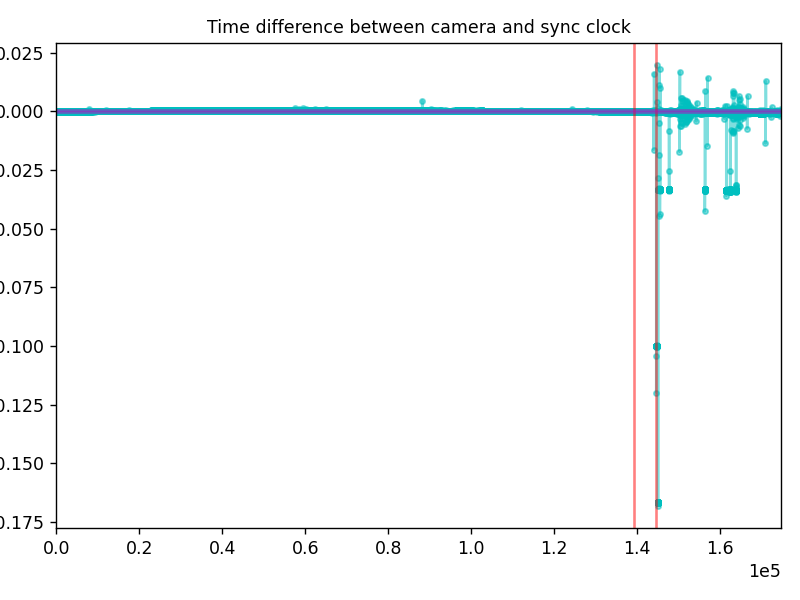

(0.0, 174750.0)

In [29]:
fig, ax = plt.subplots(tight_layout=True)
timediff = (pupil_ts[:len(pfalling)] - pupil_ts[0]) - (pfalling - pfalling[0])
# ax.plot(timediff, marker='.', color='b', alpha=0.5)
ax.plot(detrend_timediff, marker='.', color='c', alpha=0.5)
ax.set_title('Time difference between camera and sync clock')
ax.axvline(indwins[0], color='r', alpha=0.5)
ax.axvline(indwins[1], color='r', alpha=0.5)
ax.axhline(avgdt + 2*stddt, color='m', alpha=0.5)
ax.axhline(avgdt - 2*stddt, color='m', alpha=0.5)
ax.set_xlim(0, len(pfalling))